## Importing Libraries

In [ ]:
import os
import time
import torch
import torch.nn.functional as F
import torch_directml
import wandb
import numpy as np
from tqdm import tqdm
import h5py
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

✅ Using device: privateuseone:0


Creating Graphs: 100%|██████████| 872666/872666 [00:46<00:00, 18712.51it/s]
c:\Users\vudut\anaconda3\envs\pytorchamd\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Batch 100: Loss = 0.6793, Accuracy = 0.6875
Epoch 1, Batch 200: Loss = 0.7024, Accuracy = 0.5625
Epoch 1, Batch 300: Loss = 0.6968, Accuracy = 0.5625
Epoch 1, Batch 400: Loss = 0.6698, Accuracy = 0.5938
Epoch 1, Batch 500: Loss = 0.6246, Accuracy = 0.6562
Epoch 1, Batch 600: Loss = 0.6981, Accuracy = 0.5000
Epoch 1, Batch 700: Loss = 0.6163, Accuracy = 0.6875
Epoch 1, Batch 800: Loss = 0.7367, Accuracy = 0.5312
Epoch 1, Batch 900: Loss = 0.5997, Accuracy = 0.6250
Epoch 1, Batch 1000: Loss = 0.6382, Accuracy = 0.6250
Epoch 1, Batch 1100: Loss = 0.6256, Accuracy = 0.6250
Epoch 1, Batch 1200: Loss = 0.5501, Accuracy = 0.7812
Epoch 1, Batch 1300: Loss = 0.6225, Accuracy = 0.6875
Epoch 1, Batch 1400: Loss = 0.6035, Accuracy = 0.6875
Epoch 1, Batch 1500: Loss = 0.5577, Accuracy = 0.7500
Epoch 1, Batch 1600: Loss = 0.5302, Accuracy = 0.7188
Epoch 1, Batch 1700: Loss = 0.6545, Accuracy = 0.7500
Epoch 1, Batch 1800: Loss = 0.6947, Accuracy = 0.5938
Epoch 1, Batch 1900: Loss = 0.6130, A

Batch,▃▄▄▅▆▂█▃▃▄▁▇▇▁▄▅▅▅▆▃▇▇█▂▃▃▆▂▄▄▂▅▂▃▄▇█▂▄▆
Batch Accuracy,▄▇▅▄▅▆▅▆▆▅▅▅▄▅▄▆▆▆▆▅▅▅▁▅▄▆▅▄▆▄▇▃▅▅▄▇▄▂█▄
Batch Loss,▂▅▅▄▆█▅▅▅▆▃▅▆▅▄▃▄▅▄▁▆▄▁▆▅█▁▄▁▅▄▄▅▆▆▇▃▅▃▅
Epoch,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇████
Epoch Time (s),▄▁▇▃▄▇▇██▅▂
Train Accuracy,▂▁▇████████
Train Loss,▇█▂▁▁▁▂▂▁▁▂
Validation Accuracy,▁▂▁▃▃▅█▄▂▆▃
Batch,21800
Batch Accuracy,0.59375
Batch Loss,0.63602


## Initializing weights and biases and setting up the GPU

In [ ]:

# Initialize Weights & Biases (W&B) for experiment tracking
wandb.init(project="higgs_gnn", name="gnn_training_final", config={"epochs": 20, "batch_size": 32})

# Set device to AMD GPU using DirectML
device = torch_directml.device()
print(f"✅ Using device: {device}")


## Loading the daaset and creating the geaph data

In [ ]:

# Load HDF5 dataset
hdf5_file = r"C:\Users\vudut\OneDrive\Desktop\Python\MINI Project\Data Sets\jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5"
with h5py.File(hdf5_file, "r") as f:
    jet_pt = np.array(f["jet_pt"])
    jet_eta = np.array(f["jet_eta"])
    jet_phi = np.array(f["jet_phi"])
    jet_mass = np.array(f["jet_mass"])
    signal = np.array(f["signal"])  # Labels: 1 = Signal, 0 = Background

# Normalize node features (jet_pt, jet_eta, jet_phi, jet_mass)
features = np.stack([jet_pt, jet_eta, jet_phi, jet_mass], axis=1)  # Shape: [N, 4]
features = (features - features.mean(axis=0)) / features.std(axis=0)  # Standardization


In [ ]:

# Create graph data with explicit self-loops
graphs = []
for i in tqdm(range(len(features)), desc="Creating Graphs"):
    x = torch.tensor(features[i], dtype=torch.float).unsqueeze(0)
    edge_index = torch.tensor([[0], [0]], dtype=torch.long)
    y = torch.tensor([int(signal[i])], dtype=torch.long)
    graphs.append(Data(x=x, edge_index=edge_index, y=y))


## Creating Dataloaders

In [ ]:

# Create DataLoaders for training and validation
batch_size = 32
train_loader = DataLoader(
    graphs[:int(0.8 * len(graphs))],
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
val_loader = DataLoader(
    graphs[int(0.8 * len(graphs)):],
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


## Creating a GNN model

In [ ]:

# Define the GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(4, 16, add_self_loops=False)
        self.conv2 = GCNConv(16, 32, add_self_loops=False)
        self.fc = torch.nn.Linear(32, 2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = global_mean_pool(x, batch)
        return self.fc(x)

# Initialize model, optimizer, and loss function
model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()


## Training the GNN model

In [ ]:

# Training loop with epoch timing
for epoch in range(10):
    start_time = time.time()
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    batch_counter = 0

    for batch in train_loader:
        batch_counter += 1
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == batch.y).sum().item()
        total += batch.y.size(0)

        if batch_counter % 100 == 0:
            batch_loss = loss.item()
            batch_acc = (pred == batch.y).sum().item() / batch.y.size(0)
            print(f"Epoch {epoch+1}, Batch {batch_counter}: Loss = {batch_loss:.4f}, Accuracy = {batch_acc:.4f}")
            wandb.log({"Batch Loss": batch_loss, "Batch Accuracy": batch_acc, "Epoch": epoch+1, "Batch": batch_counter})

    epoch_time = time.time() - start_time
    avg_loss = total_loss / len(train_loader)
    train_acc = correct / total
    print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Train Accuracy = {train_acc:.4f}, Time = {epoch_time:.2f}s")
    wandb.log({
        "Train Loss": avg_loss,
        "Train Accuracy": train_acc,
        "Epoch Time (s)": epoch_time,
        "Epoch": epoch+1
    })

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch)
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
    val_acc = correct / total
    print(f"Validation Accuracy: {val_acc:.4f}")
    wandb.log({"Validation Accuracy": val_acc, "Epoch": epoch+1})


## Saving the model

In [ ]:

# Save the trained model and finish W&B
torch.save(model.state_dict(), "higgs_gnn_model_final.pth")
wandb.finish()


## Saving graphs for evaluation

In [1]:
import h5py
import numpy as np
import torch
from torch_geometric.data import Data
from tqdm import tqdm
import os
import json

# Load HDF5 dataset
hdf5_file = r"C:\Users\vudut\OneDrive\Desktop\Python\MINI Project\Data Sets\jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5"
with h5py.File(hdf5_file, "r") as f:
    jet_pt = np.array(f["jet_pt"])
    jet_eta = np.array(f["jet_eta"])
    jet_phi = np.array(f["jet_phi"])
    jet_mass = np.array(f["jet_mass"])
    signal = np.array(f["signal"])  # Labels: 1 = Signal, 0 = Background

# Normalize node features (jet_pt, jet_eta, jet_phi, jet_mass)
features = np.stack([jet_pt, jet_eta, jet_phi, jet_mass], axis=1)  # Shape: [N, 4]
features = (features - features.mean(axis=0)) / features.std(axis=0)  # Standardization

# Create and save 20 graphs in JSON format
output_dir = r"C:\Users\vudut\OneDrive\Desktop\Python\MINI Project\test_graphs_json"
os.makedirs(output_dir, exist_ok=True)

for i in tqdm(range(20), desc="Creating and Saving Graphs"):
    x = torch.tensor(features[i], dtype=torch.float).unsqueeze(0)
    edge_index = torch.tensor([[0], [0]], dtype=torch.long)
    y = torch.tensor([int(signal[i])], dtype=torch.long)
    
    # Convert graph to dictionary
    graph_dict = {
        "x": x.tolist(),  # Node features as list
        "edge_index": edge_index.tolist(),  # Edge indices as list
        "y": y.tolist()  # Label as list
    }
    
    # Save as JSON
    output_path = os.path.join(output_dir, f'graph_{i}.json')
    with open(output_path, 'w') as f:
        json.dump(graph_dict, f)

print(f"Saved 20 graphs as JSON files to {output_dir}")

Creating and Saving Graphs: 100%|██████████| 20/20 [00:00<00:00, 1155.54it/s]

Saved 20 graphs as JSON files to C:\Users\vudut\OneDrive\Desktop\Python\MINI Project\test_graphs_json


## Eval the model on those 20 sample graphs

In [4]:
import torch_directml

# Initialize DirectML device
device = torch_directml.device()

# Load model with DirectML
model = GNN().to(device)
model.load_state_dict(torch.load('higgs_gnn_model_final.pth', map_location=device))
model.eval()

GNN(
  (conv1): GCNConv(4, 16)
  (conv2): GCNConv(16, 32)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [6]:
import torch
import torch_directml
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F

# 1. Define your GNN model class (same as during training)
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(4, 16, add_self_loops=False)
        self.conv2 = GCNConv(16, 32, add_self_loops=False)
        self.fc = torch.nn.Linear(32, 2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = global_mean_pool(x, batch)
        return self.fc(x)

# 2. Initialize DirectML
device = torch_directml.device()

# 3. Load and convert the model
model = GNN().to(device)
model.load_state_dict(torch.load('higgs_gnn_model_final.pth'))

# 4. Save as CPU-compatible version
cpu_model = GNN().cpu()
cpu_model.load_state_dict(model.state_dict())
torch.save(cpu_model.state_dict(), 'higgs_gnn_model_cpu.pth')

c:\Users\vudut\anaconda3\envs\pytorchamd\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
c:\Users\vudut\anaconda3\envs\pytorchamd\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Accuracy: 0.8000
AUC-ROC: nan
Confusion Matrix:
[[ 0  0]
 [ 4 16]]


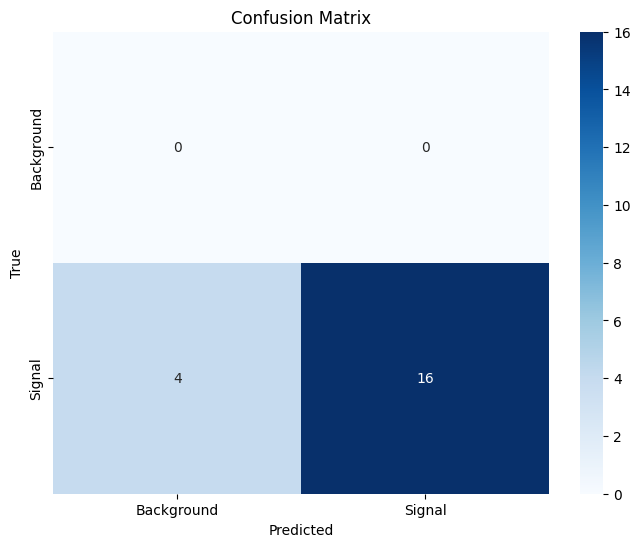

In [7]:
import torch
import json
import os
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define the GNN model (same architecture)
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(4, 16, add_self_loops=False)
        self.conv2 = GCNConv(16, 32, add_self_loops=False)
        self.fc = torch.nn.Linear(32, 2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = global_mean_pool(x, batch)
        return self.fc(x)

# 2. Load the CPU-converted model
device = torch.device('cpu')
model = GNN().to(device)
model.load_state_dict(torch.load('higgs_gnn_model_cpu.pth', map_location='cpu'))
model.eval()

# 3. Function to load JSON graph files
def load_json_graphs(directory):
    graph_files = [f for f in os.listdir(directory) if f.endswith('.json')]
    test_graphs = []
    
    for file in graph_files:
        with open(os.path.join(directory, file), 'r') as f:
            graph_data = json.load(f)
            
            x = torch.tensor(graph_data['x'], dtype=torch.float).to(device)
            edge_index = torch.tensor(graph_data['edge_index'], dtype=torch.long).to(device)
            y = torch.tensor([graph_data['y']], dtype=torch.long).to(device)
            
            test_graphs.append(Data(x=x, edge_index=edge_index, y=y))
    
    return test_graphs

# 4. Load and evaluate
test_graphs_dir = r"C:\Users\vudut\OneDrive\Desktop\Python\MINI Project\test_graphs_json"
test_graphs = load_json_graphs(test_graphs_dir)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            probs = F.softmax(out, dim=1)
            
            _, preds = torch.max(out, 1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
    
    return all_labels, all_preds, all_probs

# Run evaluation
true_labels, predictions, probabilities = evaluate_model(model, test_loader)

# Calculate and display metrics
accuracy = accuracy_score(true_labels, predictions)
auc_roc = roc_auc_score(true_labels, probabilities)
conf_matrix = confusion_matrix(true_labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Background', 'Signal'],
            yticklabels=['Background', 'Signal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()